In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import sys
import datetime
import iris
from pyhdf.SD import SD, SDC
import time
import xarray as xr
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression


from cis import read_data, read_data_list, get_variables

In [15]:

def load_emis(emis_dir, month, crop_max=10):
    filelist=glob.glob(emis_dir + month + ".nc")
    da=xr.open_mfdataset(filelist)
    da['SOx']=xr.where(da['SOx']<0, 0, da['SOx'])
    da['SOx']=xr.where(da['SOx']>crop_max, 0, da['SOx'])
    return da['SOx'].transpose('latitude', 'longitude', 'time')

def load_modis(modis_dir, month, crop_max=100):
    filelist=glob.glob(modis_dir + '2018' + month + "*.nc")
    ds=xr.open_mfdataset(filelist)
    #print('loading done, starting to process')

    re=ds['Cloud_Effective_Radius'].where(ds['Cloud_Top_Temperature'] > 272.15-15, np.nan)
    
    print(np.isnan(re).values.sum()/(np.logical_not(np.isnan(re)).values.sum()+np.isnan(re).values.sum()))
    re=re.where(ds['Cloud_Effective_Radius_Uncertainty']<8, np.nan)
    print(np.isnan(re).values.sum()/(np.logical_not(np.isnan(re)).values.sum()+np.isnan(re).values.sum()))
    re=xr.where(re>1000, np.nan, re)
    re=xr.where(re<4, np.nan, re)
    print(np.isnan(re).values.sum()/(np.logical_not(np.isnan(re)).values.sum()+np.isnan(re).values.sum()))
    
    return re


def coarsened_emis(emis, window_size=3):
    emis_coarsened=emis.rolling(latitude=window_size, longitude=window_size,
                                min_periods=1, center=True).reduce(np.mean)
    return emis_coarsened

#expects one variable xr.DaraArray, returns this array filtered for those values that occur 
#'hours' before the modis overpass which is around 18-19h UTC
def time_collapse_emis(da, hours, overpass_hour=19):
    days_in_month=len(da.time.values)//24
    hours_ind=[]
    #print(da.isel(time=slice(24+hours_ind[0].astype(int),hours_ind[-1].astype(int))))
    if overpass_hour-hours<0:
        for i in range(days_in_month-1):
            for j in range(hours):
                hours_ind=np.append(hours_ind,(i+1)*24+overpass_hour-hours+j)
        emis=da.isel(time=hours_ind.astype(int))
        #print(emis.time)
        emis=emis.resample(time='24H', base=24+overpass_hour-hours, closed='left')
        #print("Caution: No data for the first day of the month")
    elif overpass_hour>24:
        for i in range(days_in_month-1):
            for j in range(hours):
                hours_ind=np.append(hours_ind,i*24+overpass_hour-hours+j)
        emis=da.isel(time=hours_ind.astype(int))
        #print(emis.isel(time=0).mean().values)
        emis=emis.resample(time='24H', base=overpass_hour-hours, closed='left')
        #print("Caution: No data for the first day of the month")
    else:
        for i in range(days_in_month):
            for j in range(hours):
                hours_ind=np.append(hours_ind,i*24+overpass_hour-hours+j)
        emis=da.isel(time=hours_ind.astype(int))
        #print(emis.isel(time=0).mean().values)
        emis=emis.resample(time='24H', base=overpass_hour-hours, closed='left')

    emis=emis.reduce(np.mean)
    return emis

In [16]:
def select_lonlats(emissions_da, r_eff_da, lats, lons):
    emis=emissions_da.sel(longitude=lons,latitude=lats)
    re=r_eff_da.sel(longitude=lons,latitude=lats)
    return re, emis

def select_data(r_eff_da,emissions_da, 
                lats=slice(-35,0), lons=slice(-90,-70), 
                coarsening=3, 
                end_h=19, emis_h=1):
    
    re, emis=select_lonlats(emissions_da, r_eff_da, lats, lons)
    #print(re.mean().values)
    emis=time_collapse_emis(emis, emis_h, overpass_hour=end_h)
    
    # if the emis collapse does not reach into the day before, we need to 
    if end_h-emis_h>=0: emis=emis.isel(time=slice(1, len(emis.time)))
    # if the end_hour of emission collapse is after midnight, everything good,
    # because we get rid of the last modis day anyway. If not, we need to get rid of the last emis day
    if end_h<=24: emis=emis.isel(time=slice(0, len(emis.time)-1))
    
    #always crop the first day of sat_image
    re=re.isel(time=slice(1, len(re.time)-1))
    #print(re.mean().values)
    emis=coarsened_emis(emis, window_size=coarsening)
    #print(re.mean().values)

    
    return re, emis

In [17]:
# returns the effect of pollution on the size of cloud droplets 
def re_diff_emis(threshold, re, emis):
    
    #print("division middle")
    prist=np.where(emis > threshold, np.nan, re)

    #prist=np.where(emis == 0., np.nan, prist)
    re_prist=np.nanmean(prist)
    pristpoints=np.logical_not(np.isnan(prist)).sum()

#     s=np.shape(re)
#     x=np.random.rand(s[0],s[1],s[2])
#     poll=np.where(x <= 0.02, np.nan, re)
    poll=np.where(emis <= threshold, np.nan, re)
    re_poll=np.nanmean(poll)
    re_pollvar=np.nanvar(poll)
    pollpoints=np.logical_not(np.isnan(poll)).sum()
    
    return re_prist,re_poll, pollpoints, pristpoints, re_pollvar

def re_diff_emis2(threshold, re, emis):
    
    #print("division middle")
    prist=np.where(emis > threshold, np.nan, re)
    poll=np.where(emis <= threshold, np.nan, re)
    
    re_prist=[]
    pristpoints=[]
    re_poll=[]
    re_pollvar=[]
    pollpoints=[]
    
    for d in range(np.shape(prist)[2]):
        re_prist.append(np.nanmean(prist[:,:,d]))
        pristpoints.append(np.logical_not(np.isnan(prist[:,:,d])).sum())
        
        re_poll.append(np.nanmean(poll[:,:,d]))
        re_pollvar.append(np.nanvar(poll[:,:,d]))
        pollpoints.append(np.logical_not(np.isnan(poll[:,:,d])).sum())
    
    return re_prist,re_poll, pollpoints, pristpoints, re_pollvar


# returns a list values of mean droplet sizes in different emission bins 
def re_emis_bins(re, emis, up_to=1, bins=20):
    binsize=up_to/bins
    re_mean=[]
    for i in range(bins):
        ra=np.where(emis < i*binsize, np.nan, re)
        #print(ra)
        ra=np.where(emis >= (i+1)*binsize, np.nan, ra)
        ra_mean=np.nanmean(ra)
        ra_points=np.nansum(ra)/ra_mean
        re_mean.append([i*binsize ,ra_mean, ra_points])
    return np.transpose(re_mean)

In [18]:
# hour_poll_prist=np.array(hour_poll_prist)
# hour_poll_prist[:,1,:]=np.where(hour_poll_prist[:,2,:]>20, hour_poll_prist[:,1,:], np.nan )
# plt.figure(figsize=(20, 10))
# for day in range(np.shape(hour_poll_prist)[2]):
#     plt.plot(np.linspace(-21, 48, 24), hour_poll_prist[:,1,day], c = plt.cm.viridis(day/np.shape(hour_poll_prist)[2]) )
# plt.plot(np.linspace(-21, 48, 24), np.nanmean(hour_poll_prist[:,1,:], axis=1))

In [19]:
modis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis_aqua/'
emis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/downsampled_emis/'
save_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/ds_timecoll_emis/'

(array([100525., 295526., 398516., 278753., 192972., 131028.,  83363.,
         52300.,  35232.,  25248.]),
 array([ 3.2273553 ,  4.90461973,  6.58188415,  8.25914858,  9.936413  ,
        11.61367743, 13.29094185, 14.96820628, 16.6454707 , 18.32273513,
        19.99999955]),
 <a list of 10 Patch objects>)

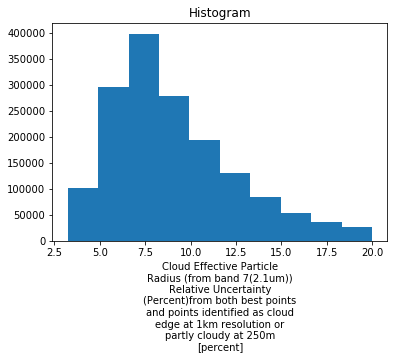

In [20]:
filelist=glob.glob(modis_dir + '2018' + '09' + "*.nc")
ds=xr.open_mfdataset(filelist)
ds['Cloud_Effective_Radius_Uncertainty'].where(ds['Cloud_Effective_Radius_Uncertainty']<20).plot()

In [21]:
# dah=load_emis(emis_dir, month='03')
# reh=load_modis(modis_dir, month='03')
# dai=load_emis(emis_dir, month='04')
# rei=load_modis(modis_dir, month='04')
# daj=load_emis(emis_dir, month='05')
# rej=load_modis(modis_dir, month='05')
# dak=load_emis(emis_dir, month='06')
# rek=load_modis(modis_dir, month='06')
dam=load_emis(emis_dir, month='07')
rem=load_modis(modis_dir, month='07')
da0=load_emis(emis_dir, month='08')
re0=load_modis(modis_dir, month='08')
da=load_emis(emis_dir, month='09')
re=load_modis(modis_dir, month='09')
da2=load_emis(emis_dir, month='10')
re2=load_modis(modis_dir, month='10')
da3=load_emis(emis_dir, month='11')
re3=load_modis(modis_dir, month='11')

0.09168110371769496
0.6603870638536021
0.6675985022959826
0.0855610743269225
0.6569948712461953
0.6605941892412764
0.08721539500975653
0.7084373951703968
0.7119832934094957
0.1579173336515657
0.7746612951235002
0.7778701383259239
0.11819723793189796
0.808631108465271
0.8130293452018161


In [22]:
# comb_da=xr.concat([dah,dai,daj,dak,dam,da0,da, da2, da3], dim='time')
# comb_re=xr.concat([reh,rei,rej,rek,rem,re0,re, re2, re3], dim='time')
comb_da=xr.concat([dam,da0,da, da2, da3], dim='time')
comb_re=xr.concat([rem,re0,re, re2, re3], dim='time')

In [10]:
if len(comb_re.coords['time'].values)-len(comb_da.coords['time'].values)/24 > 0: print('Caution! Array lenghts do not match')

In [12]:
# comb_da=xr.concat([da, da2], dim='time')
# comb_re=xr.concat([re, re2], dim='time')

In [13]:
# mask_re=(
#         (comb_re.coords['time']==np.datetime64('2018-09-03T19:02:40.063975000'))
#       & (comb_re.coords['longitude'] < -74.95)
#       & (comb_re.coords['longitude'] > -75.05)
#       & (comb_re.coords['latitude'] < -24.95)
#       & (comb_re.coords['latitude'] > -25.05)
#      )
# manip_re=comb_re.where(np.logical_not(mask_re), 1e8)
# #manip_re.sel(latitude=slice(-26,-24)).mean('time').plot()
# mask_emis=(
#         (comb_da.coords['time']==np.datetime64('2018-09-02T16:00:00.000000000'))
#       & (comb_da.coords['longitude'] < -74.95)
#       & (comb_da.coords['longitude'] > -75.05)
#       & (comb_da.coords['latitude'] < -24.95)
#       & (comb_da.coords['latitude'] > -25.05)
#      )
# manip_emis=comb_da.where(np.logical_not(mask_emis), 1e8)
# #manip_emis.sel(latitude=slice(-26,-24)).mean('time').plot()

In [14]:
# comb_re.coords['time']

In [15]:
month='10'

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1,'Effective Radius in single day')

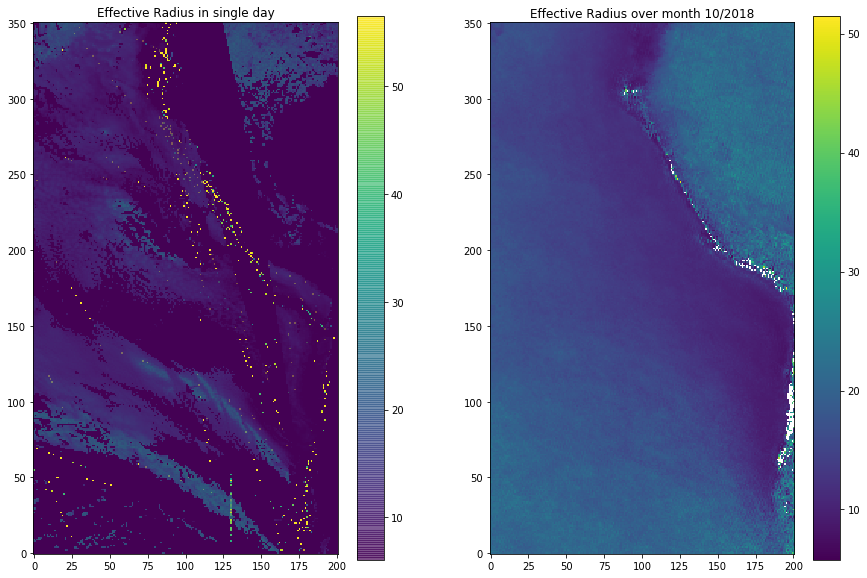

In [16]:
fig=plt.figure(figsize=(15,25))
ax1=fig.add_subplot(1,2,2)
f1=ax1.imshow(comb_re.mean('time').values,origin='lower')
fig.colorbar(f1,ax=ax1,shrink=0.4)
ax1.set_title('Effective Radius over month {}/2018'.format(month))
day=4
ax2=fig.add_subplot(1,2,1)
f2=ax2.imshow(da.groupby('time.day').reduce(np.mean).isel(day=day).values, vmax=0.1, origin='lower')
f2=ax2.imshow(re.isel(time=day).values, origin='lower', alpha=0.7)
fig.colorbar(f2,ax=ax2,shrink=0.4)
ax2.set_title('Effective Radius in single day')

Text(0.5,1,'Effective Radius in single day')

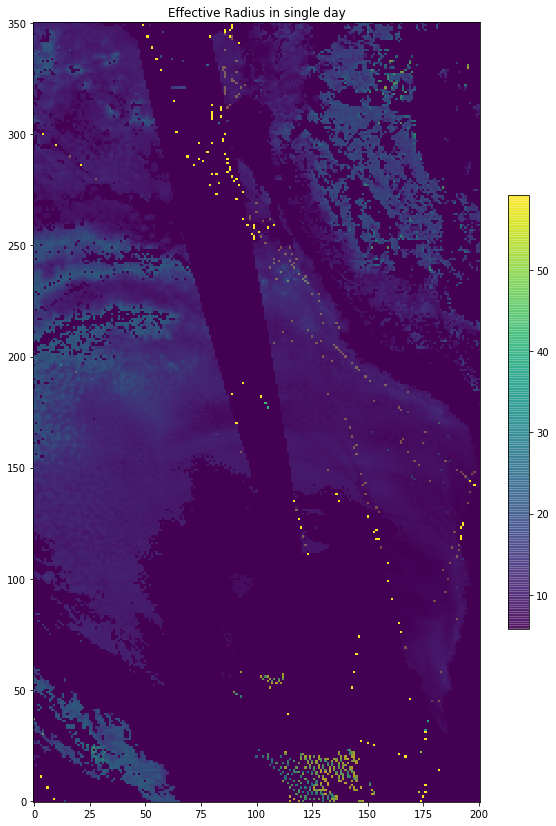

In [17]:
day=9
fig=plt.figure(figsize=(10,20))
ax2=fig.add_subplot(1,1,1)
f2=ax2.imshow(time_collapse_emis(da, hours=15, overpass_hour=18).isel(time=day).values, vmax=0.1, origin='lower')
f2=ax2.imshow(re.isel(time=day).values, origin='lower', alpha=0.7)
fig.colorbar(f2,ax=ax2,shrink=0.4)
ax2.set_title('Effective Radius in single day')

In [18]:
coarse_emis=coarsened_emis(da)

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


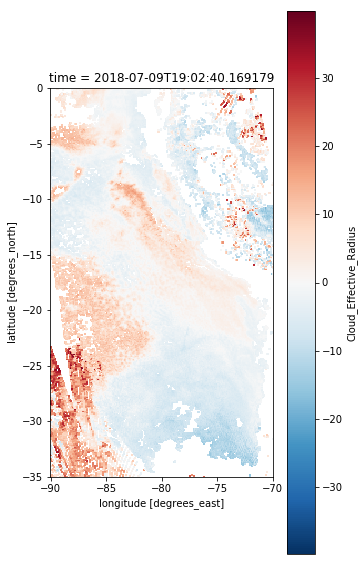

In [19]:
plt.figure(figsize=(5,10))
re_adj=comb_re-comb_re.mean('time')
re_adj.isel(time=8).plot()
plt.axes().set_aspect('equal')

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1,'Mean SOx Emissions in single hour')

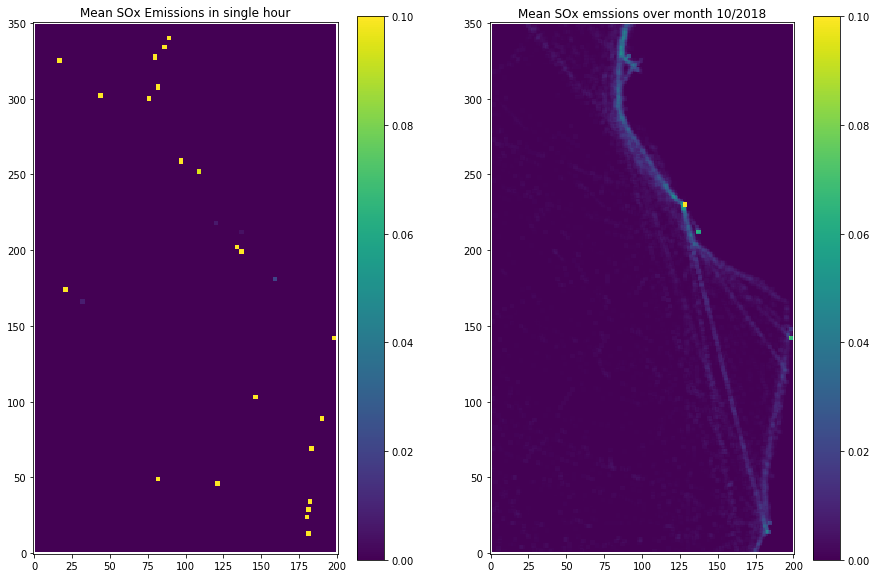

In [20]:
fig=plt.figure(figsize=(15,25))
ax1=fig.add_subplot(1,2,2)
f1=ax1.imshow(coarse_emis.mean('time').values, vmax=0.1, origin='lower')
fig.colorbar(f1,ax=ax1, shrink=0.4)
ax1.set_title('Mean SOx emssions over month {}/2018'.format(month))

ax2=fig.add_subplot(1,2,1)
f2=ax2.imshow(coarse_emis.isel(time=1).values, vmax=0.1, origin='lower')
fig.colorbar(f2,ax=ax2,shrink=0.4)
ax2.set_title('Mean SOx Emissions in single hour')

In [23]:
adj_re=comb_re-comb_re.isel(time=slice(1,len(comb_re.time)-1)).mean('time')
#lats=slice(-35,-17), lons=slice(-77.5,-72.5)
hour_poll_prist=[]
for hour in np.linspace(-21, 48, 24):
    print(hour)
    re_sel, emis_sel=select_data(adj_re,comb_da, emis_h=3,end_h=hour,lats=slice(-35,-17), lons=slice(-77.5,-72.5), coarsening=1)
    re_prist,re_poll, pollpoints, pristpoints, re_pollvar=re_diff_emis(0.0,re_sel, emis_sel)
    hour_poll_prist.append([hour-19, re_prist,re_poll, pollpoints, re_pollvar])

-21.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-18.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-15.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-12.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-9.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-6.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-3.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


6.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


9.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


12.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


15.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


18.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


21.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


24.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


27.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


30.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


33.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


36.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


39.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


42.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


45.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


48.0


/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [12]:
np.linspace(-21, 48, 24)

array([-21., -18., -15., -12.,  -9.,  -6.,  -3.,   0.,   3.,   6.,   9.,
        12.,  15.,  18.,  21.,  24.,  27.,  30.,  33.,  36.,  39.,  42.,
        45.,  48.])

Text(0,0.5,'r_eff')

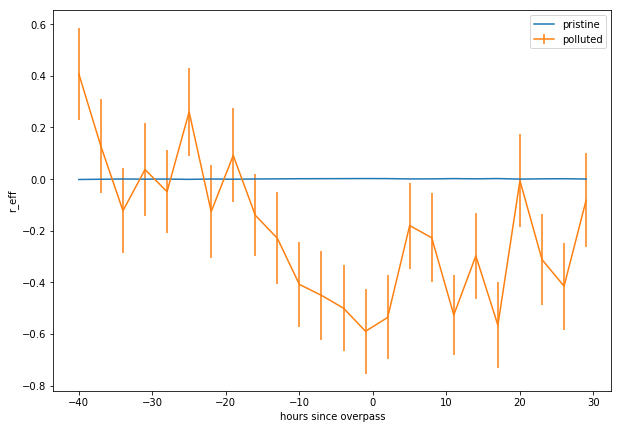

In [24]:
plt.figure(figsize=(10,7))
arr=np.transpose(hour_poll_prist)
plt.plot(arr[0], arr[1])
plt.errorbar(arr[0], arr[2], np.sqrt(arr[4]/arr[3]))
plt.legend(['pristine', 'polluted'])
plt.xlabel('hours since overpass')
plt.ylabel('r_eff')

Text(0.5,1,'Mean SOx Emissions in observation period')

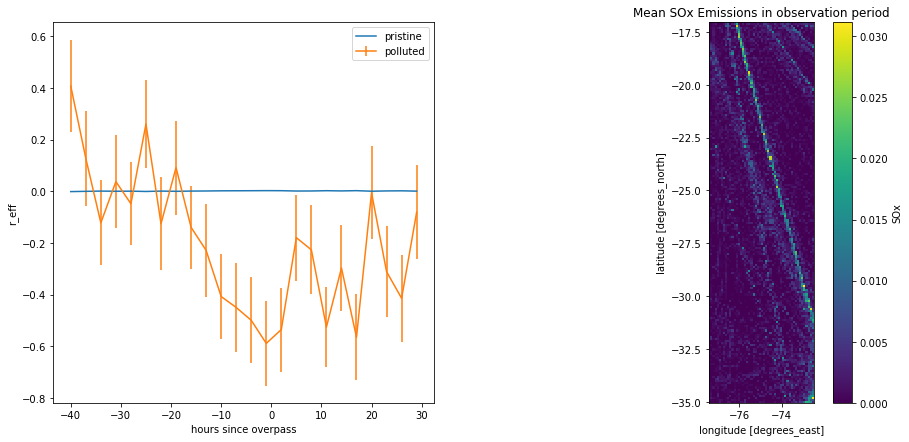

In [25]:
fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(1,2,1)
ax1.plot(arr[0], arr[1])
ax1.errorbar(arr[0], arr[2], np.sqrt(arr[4]/arr[3]))
ax1.legend(['pristine', 'polluted'])
ax1.set_xlabel('hours since overpass')
ax1.set_ylabel('r_eff')

ax2=fig.add_subplot(1,2,2)
comb_da.sel(latitude=slice(-35,-17), longitude=slice(-77.5,-72.5)).mean('time').plot()
ax2.set_aspect('equal')
ax2.set_title('Mean SOx Emissions in observation period')


In [ ]:
relate,emlate=select_data(adj_re,comb_da, emis_h=10,end_h=47,lats=slice(-35,-17), lons=slice(-77.5,-72.5))

In [ ]:
reearl,emearl=select_data(adj_re,comb_da, emis_h=10,end_h=19,lats=slice(-35,-17), lons=slice(-77.5,-72.5))

In [ ]:
(emearl.mean('time')-emlate.mean('time')).plot()
plt.axes().set_aspect('equal')

In [ ]:
arr=np.transpose(hour_poll_prist)
plt.plot(arr[0], arr[3])
plt.xlabel('hours since overpass')
plt.ylabel('r_eff')

In [ ]:
re_sel, emis_sel=select_data(adj_re,comb_da, 
                             emis_h=20,end_h=29,
                             lats=slice(-35,-17), lons=slice(-77.5,-72.5),
                             coarsening=1)

In [ ]:
X=emis_sel.values.flatten()
Y=re_sel.values.flatten()

In [ ]:
plt.figure(figsize=(10,7))
#range=[[0.0, 2], [-30, 30]]
plt.hist2d(X,Y, bins=30,range=[[0.0, 2], [-30, 30]],norm=LogNorm())
plt.ylabel('r_eff')
plt.xlabel('emissions in the past 7h')
plt.colorbar()

In [ ]:
X=X[np.logical_not(np.isnan(Y))]
Y=Y[np.logical_not(np.isnan(Y))]

In [ ]:
X_t=np.where(X>0.0, 1, 0)
n=len(Y)
regr = LinearRegression(
   fit_intercept = True).fit(X_t.reshape(-1, 1),Y)
print(regr.coef_)
RSS_2=((regr.predict(X_t.reshape(-1, 1)) - Y) ** 2).sum()
RSS_1=((Y-np.mean(Y))**2).sum()
F=((RSS_1-RSS_2)/1)/(RSS_2/(n-2))
F

In [ ]:
re_diff_emis(0.0,re,emis)

In [ ]:
re_mean=re_emis_bins(re, emis, 0.5, 20)

In [ ]:
fig=plt.figure(figsize=(20,6))

ax1=fig.add_subplot(1,2,1)
ax1.plot(re_mean[0],re_mean[1])
plt.xlabel('emissions')
plt.ylabel('r_eff')



ax2=fig.add_subplot(1,2,2, sharex=ax1)
ax2.plot(re_mean[0],np.log10(re_mean[2]))
plt.xlabel('emissions')
plt.ylabel('log(n points)')

In [ ]:
# def pop_history_callback(cube, field, filename):
#     cube.attributes.pop("history")
#     return cube

# dati=iris.load('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis/*.nc',
#                   ['Cloud_Top_Temperature',
#                 'Cloud_Effective_Radius'])
#collocate instead of merge

In [ ]:
#emis_plus_cloud=xr.merge([re._to_temp_dataset(), emis_coarsened._to_temp_dataset()])

In [ ]:
# emis_plus_cloud.plot.scatter(x='SOx', y='Cloud_Effective_Radius')

In [ ]:
fig=plt.figure(figsize=(20,6))

ax1=fig.add_subplot(1,2,1)
ax1.plot(re_mean[0],re_mean[1])


ax2=fig.add_subplot(1,2,2, sharex=ax1)
ax2.plot(re_mean[0],np.log10(re_mean[2]))

In [ ]:
for threshold in np.linspace(0,1,20):
    print(threshold)
    print(re_diff_emis(threshold, re.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18)), emis_coarsened.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18))))

In [ ]:
#different time-windows
#coarser resolution
#spreading with time
#discounting with time